In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df=pd.read_csv("candy_crush.csv")
df

,player_id,dt,level,num_attempts,num_success
0,6dd5af4c7228fa353d505767143f5815,2014-01-04,4,3,1
1,c7ec97c39349ab7e4d39b4f74062ec13,2014-01-01,8,4,1
2,c7ec97c39349ab7e4d39b4f74062ec13,2014-01-05,12,6,0
3,a32c5e9700ed356dc8dd5bb3230c5227,2014-01-03,11,1,1
4,a32c5e9700ed356dc8dd5bb3230c5227,2014-01-07,15,6,0
...,...,...,...,...,...
16860,e3e95924b152d5d2b0fcf0cc2b8a4261,2014-01-07,15,1,1
16861,712d953e972844194475f21b9352c1ab,2014-01-01,8,2,0
16862,7fad6b6c0d8c8a5ef69f467511b5262c,2014-01-01,9,10,1
16863,323676bf93f40dda0a96cba8c73c1478,2014-01-06,14,1,1


In [4]:
start_date=df.dt.min()
end_date=df.dt.max()
print(f"Data from {start_date} to {end_date}")

Data from 2014-01-01 to 2014-01-07


In [5]:
df = df[df.num_attempts != 258]
df.describe()


,level,num_attempts,num_success
count,16864.000000,16864.000000,16864.000000
mean,9.287120,5.520458,0.627135
std,4.343586,7.059875,0.864729
min,1.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000
50%,9.000000,3.000000,1.000000
75%,14.000000,7.000000,1.000000
max,15.000000,138.000000,55.000000


Mean attempts per record is 5.5, but std is 7.06, and max is 138.
Some users are retrying levels many times, indicating difficulty spikes or frustration.

75% of player try attempting a particular level 7 times , any player after that if likely to get frustated and churn.


Level related info

In [6]:
level_summary = df.groupby('level').agg(
    total_attempts=('num_attempts', 'sum'),
    total_successes=('num_success', 'sum')
).reset_index()

level_summary['success_rate'] = level_summary['total_successes'] / level_summary['total_attempts']
print(level_summary.sort_values('success_rate'))

    level  total_attempts  total_successes  success_rate
14     15           30374             1157      0.038092
7       8           15816              641      0.040529
8       9            8241              670      0.081301
4       5            6937              634      0.091394
11     12            6868              659      0.095952
10     11            5317              602      0.113222
6       7            4526              614      0.135661
9      10            3282              617      0.187995
13     14            2772              777      0.280303
3       4            1893              705      0.372425
5       6            1591              668      0.419862
2       3            1546              662      0.428202
12     13            1327              686      0.516956
1       2            1285              666      0.518288
0       1            1322              818      0.618759


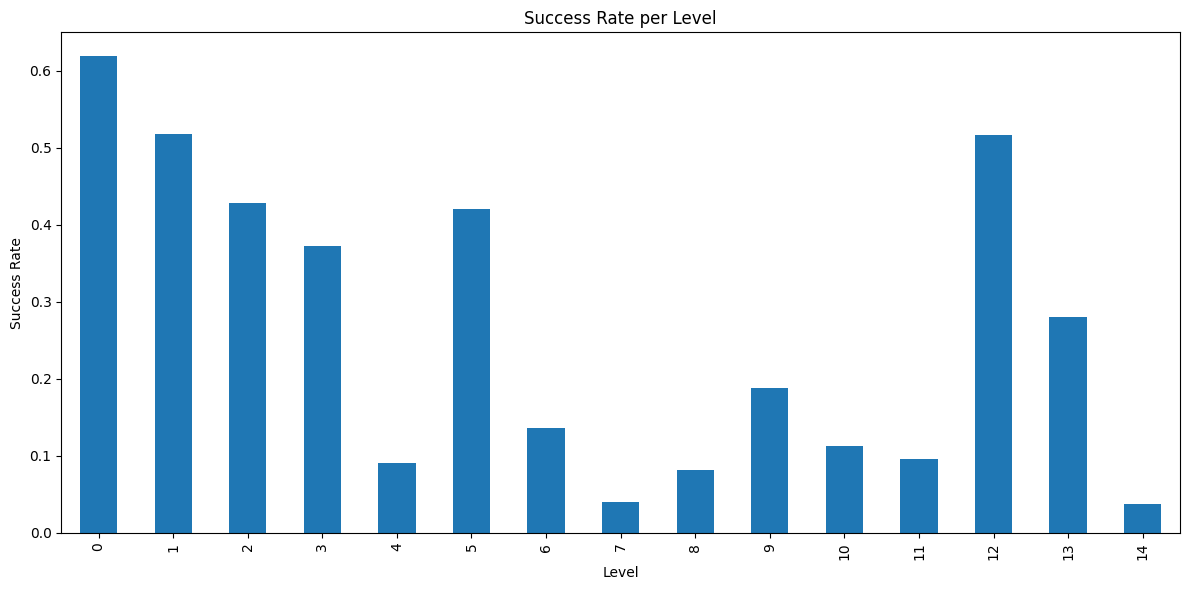

In [7]:
plt.figure(figsize=(12, 6))
level_summary['success_rate'].plot(kind='bar')
plt.title("Success Rate per Level")
plt.xlabel("Level")
plt.ylabel("Success Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


As the graph shows level number 15 is hardest with least success rate, followed by 8.
From graph it is clear that difficulty of level is not sequential as depicted by user number of attempts and number of success in those attempt for particular level.

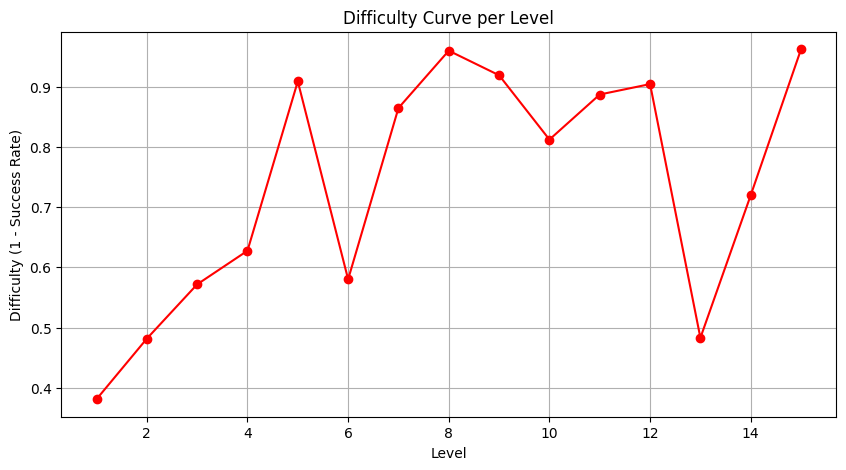

In [8]:
level_summary['difficulty']=1-level_summary['success_rate']
plt.figure(figsize=(10, 5))
plt.plot(level_summary['level'], level_summary['difficulty'], marker='o', linestyle='-', color='red')
plt.title("Difficulty Curve per Level")
plt.xlabel("Level")
plt.ylabel("Difficulty (1 - Success Rate)")
plt.grid(True)
plt.show()

Here I hae assumed diffculty of a level to be equal to 1-success_rate assuming the level which has low success rate to be difficult accordingly.

Other way of taking difficulty can be directly taking success rate which is also probability of win for that level.

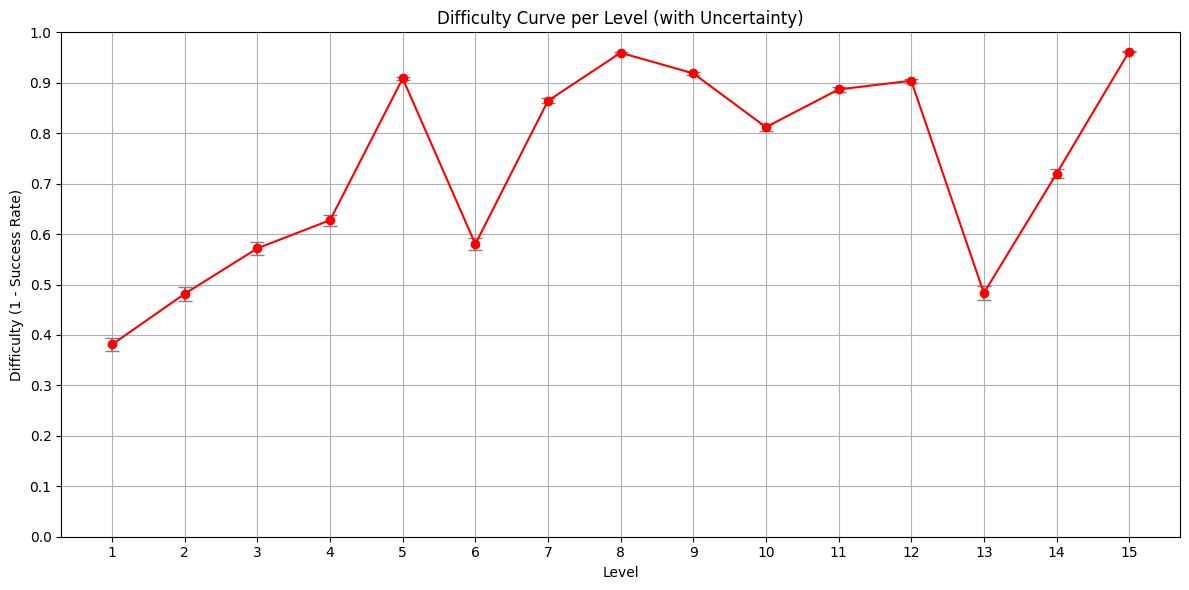

In [10]:
level_summary['uncertainty'] = np.sqrt(
    (level_summary['success_rate'] * (1 - level_summary['success_rate'])) / level_summary['total_attempts']
)

plt.figure(figsize=(12, 6))
plt.errorbar(level_summary['level'], level_summary['difficulty'], yerr=level_summary['uncertainty'], fmt='o-', color='red', ecolor='gray', capsize=5)

plt.title("Difficulty Curve per Level (with Uncertainty)")
plt.xlabel("Level")
plt.ylabel("Difficulty (1 - Success Rate)")

plt.xticks(np.arange(min(level_summary['level']), max(level_summary['level'])+1, step=1))    
plt.yticks(np.arange(0, 1.1, step=0.1))                    
plt.grid(True)
plt.tight_layout()
plt.savefig("difficulty_curve.png", dpi=300, bbox_inches='tight')
plt.show()


The graph is portraying that difficulty estimates are more certain and exact. Moreover hard levels are more precise which can help to make valid conclusions based on levels.

In [11]:

df['dt'] = pd.to_datetime(df['dt'])
latest_play = df['dt'].max()
churn_threshold_days = 3
player_last_play = df.groupby('player_id')['dt'].max()
player_churned = player_last_play < (latest_play - pd.Timedelta(days=churn_threshold_days))
df['churned'] = df['player_id'].map(player_churned)


C:\Users\Asus\AppData\Local\Temp\ipykernel_163164\1317444773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['dt'])
C:\Users\Asus\AppData\Local\Temp\ipykernel_163164\1317444773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['churned'] = df['player_id'].map(player_churned)


Here I have assumed the player as churned if s/he did not play the game further for more than 3 days.Which is just is assumption is not representative of real time scenario.

In [12]:

first_attempts = df.sort_values(['player_id', 'level', 'dt']).drop_duplicates(['player_id', 'level'])
level_churn = first_attempts.groupby('level')['churned'].mean().reset_index()
level_churn.columns = ['level', 'churn_rate']


c:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


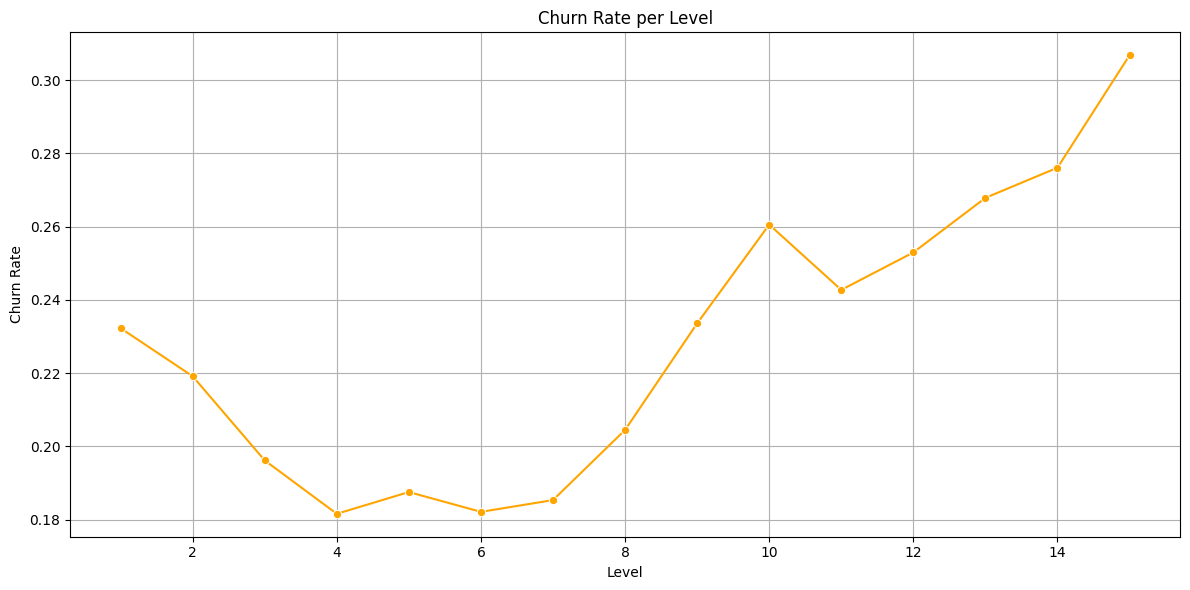

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=level_churn, x='level', y='churn_rate', marker='o', color='orange')

plt.title("Churn Rate per Level")
plt.xlabel("Level")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


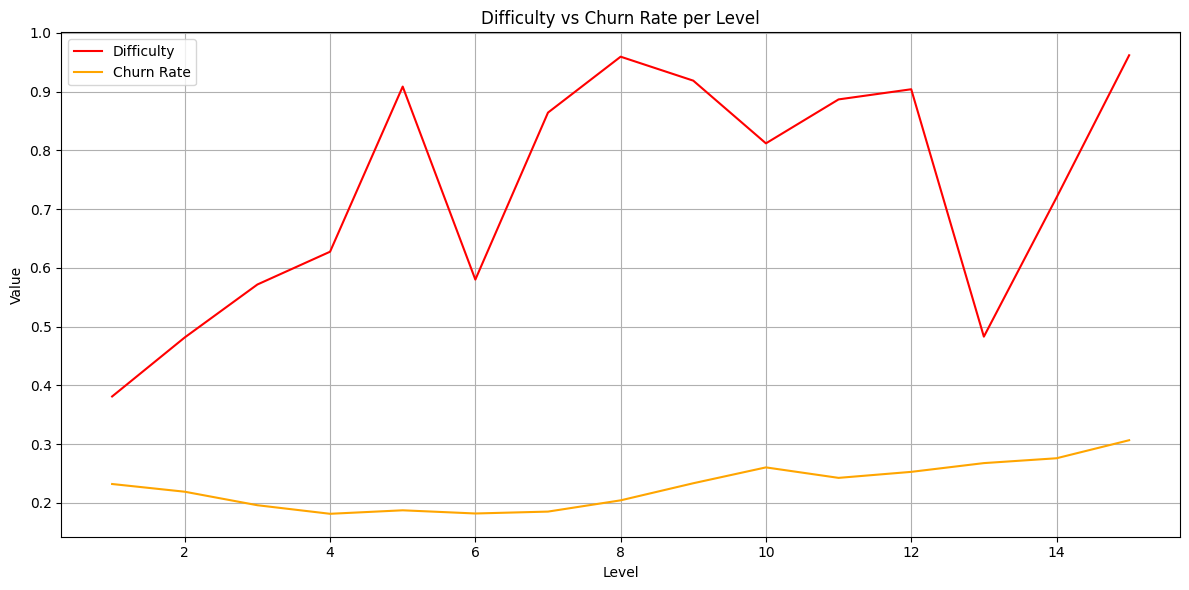

In [14]:
level_summary = level_summary.reset_index()
combined = pd.merge(level_summary, level_churn, on='level')

plt.figure(figsize=(12, 6))
plt.plot(combined['level'], combined['difficulty'], label='Difficulty', color='red')
plt.plot(combined['level'], combined['churn_rate'], label='Churn Rate', color='orange')
plt.title("Difficulty vs Churn Rate per Level")
plt.xlabel("Level")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("difficulty_churn_curve.png", dpi=300, bbox_inches='tight')
plt.show()


Here churn is more prevelant after easy levels like 1,2,3 as compared ot challenging levels like 4-8 which can be the case of boredom due to easy levels. 
** The churn at 15 is high becuase there is no level further to it and player may leave after that assuming player playes game sequentially.